In [21]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
import numpy as np
import os
import pickle
from skimage.transform import rescale, rotate
import noise
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
plt.rcParams['figure.figsize'] = [15, 5]
import sys
sys.path.insert(1, os.getcwd()+"/../..") # Not needed if you installed SyMBac using pip
from SyMBac.drawing import raster_cell
from SyMBac.colony_simulation import ColonySimulation

#Remove directory data if it exists
if os.path.exists("data"):
    os.system("rm -rf data")

In [23]:
colonysim = ColonySimulation(
    cellmodeller_model= 'dx_test_model.py',
    max_cells = 5,
    pix_mic_conv = 0.065,
    resize_amount = 1,
    save_dir = "dx_test/",
)

colonysim.run_cellmodeller_sim(num_sim=1)
colonysim.get_simulation_dirs()
pickles = colonysim.get_simulation_pickles()
colonysim.get_max_scene_size()

FRAME_CNT = len(pickles[-1])

Creating directory data/dx_test/
Set up OpenCL context:
  Platform: NVIDIA CUDA
  Device: NVIDIA GeForce GTX 1650
Importing model dx_test_model
    0     2 cells       1 cts       0 iterations  residual = 0.000000
      10           4 cells           6 contacts    0.000049 hour(s) or 0.002939 minute(s) or 0.176343 second(s)
   10     4 cells       4 cts       3 iterations  residual = 0.000063
      20           4 cells           4 contacts    0.000082 hour(s) or 0.004943 minute(s) or 0.296586 second(s)
   20     4 cells       4 cts       1 iterations  residual = 0.001518
      30           4 cells           4 contacts    0.000113 hour(s) or 0.006787 minute(s) or 0.407246 second(s)
   30     4 cells       4 cts       1 iterations  residual = 0.001867
      40           4 cells           4 contacts    0.000143 hour(s) or 0.008594 minute(s) or 0.515626 second(s)
   40     4 cells       4 cts       1 iterations  residual = 0.002296
      50           4 cells           4 contacts    0.00017

In [24]:
colonysim.draw_simulation_OPL(n_jobs = 1, FL=True, density = 0.1, random_distribution = "uniform", distribution_args = (0.9, 3))

Scene Draw:: 0it [00:00, ?it/s]

In [25]:
from SyMBac.colony_renderer import ColonyRenderer
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
from skimage.util import random_noise
from scipy.ndimage import gaussian_filter

from skimage.exposure import rescale_intensity


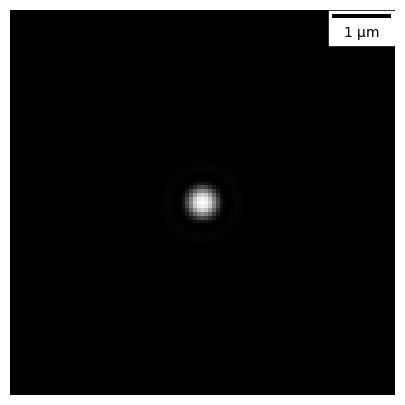

In [26]:
my_kernel = PSF_generator(
    radius = 50, 
    wavelength = 0.75, 
    NA = 1.45, 
    n = 1.4, 
    resize_amount = 1, 
    pix_mic_conv = 0.065, 
    apo_sigma = 8, 
    mode="simple fluo", 
    condenser = "Ph3",
    offset = 0.02
)
eye  = PSF_generator(
    radius = 0, 
    wavelength = 0.75, 
    NA = 1.45, 
    n = 1.4, 
    resize_amount = 1, 
    pix_mic_conv = 0.065, 
    apo_sigma = 8, 
    mode="simple fluo", 
    condenser = "Ph3",
    offset = 0.02
)
my_kernel.calculate_PSF()
my_kernel.plot_PSF()

/home/boomalope/symbac/symbac/tests/dx_test_env/../../SyMBac/PSF.py:178: RuntimeWarning: invalid value encountered in divide
  PSF = (2 * jv(1, rr) / (rr)) ** 2


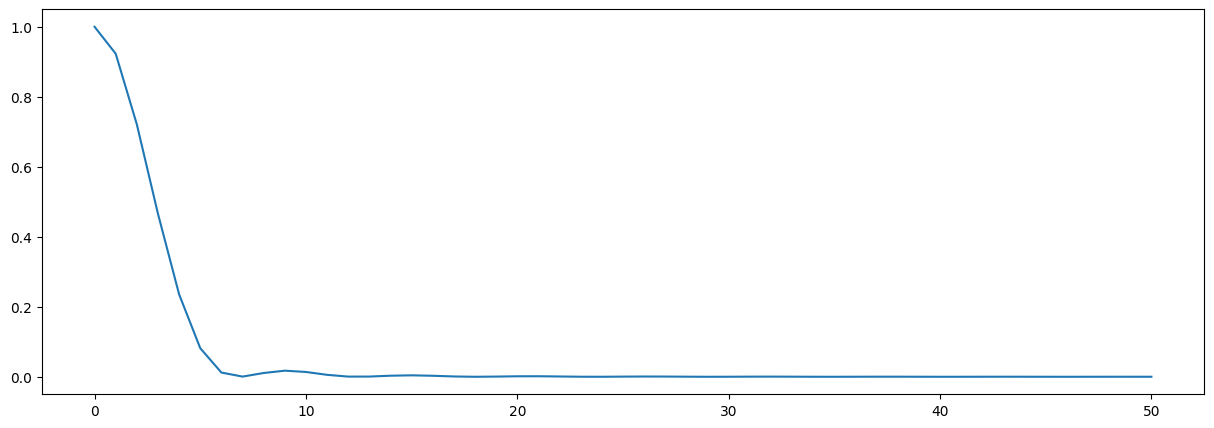

In [27]:
psf = my_kernel.get_fluorescence_kernel(my_kernel.wavelength,my_kernel.NA,my_kernel.n,my_kernel.radius,my_kernel.scale)
size = psf.shape[1]
central_psf = psf[psf.shape[1]//2]
central_psf = central_psf[len(central_psf)//2:]
plt.plot(central_psf)
with open('psf.pkl', 'wb') as file: 
    pickle.dump(central_psf, file)

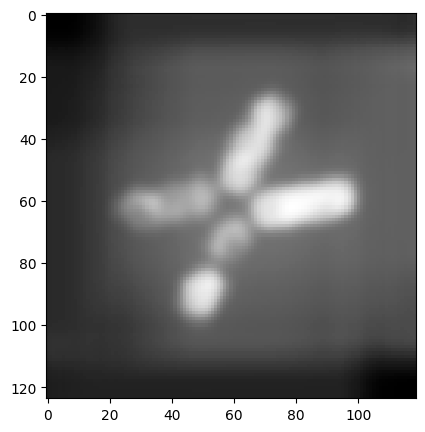

In [28]:
my_renderer = ColonyRenderer(colonysim, my_kernel)
test_img = my_renderer.render_scene(-1)
mask = my_renderer.mask_loader(-1)
plt.imshow(test_img, cmap="Greys_r")

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

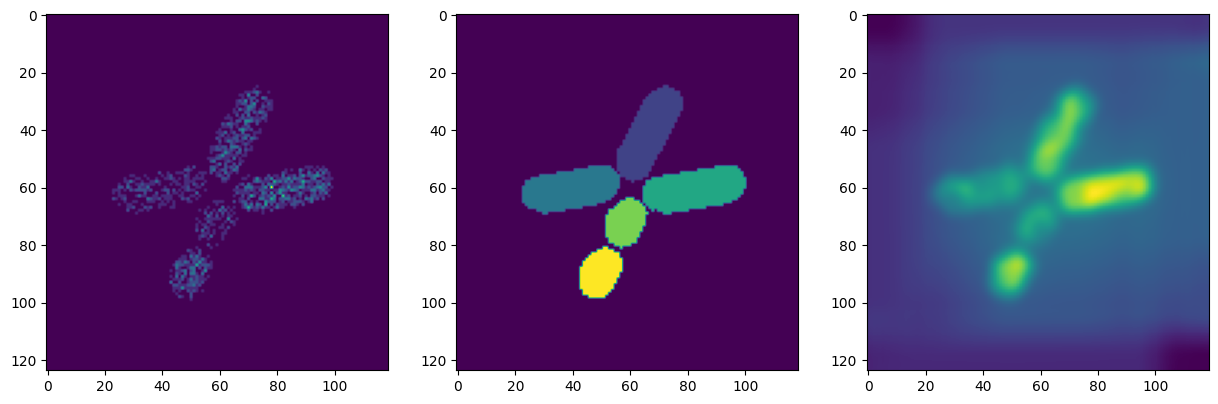

In [30]:
original = mpimg.imread('/home/boomalope/symbac/symbac/tests/dx_test_env/data/scenes/00{frame}.png'.format(frame=FRAME_CNT))
mask = mpimg.imread('/home/boomalope/symbac/symbac/tests/dx_test_env/data/masks/00{frame}.png'.format(frame=FRAME_CNT))    

#original = NormalizeData(original)
#mask = NormalizeData(mask)
#test_img = NormalizeData(test_img)
f, axarr = plt.subplots(1,3)
axarr[0].plot(100,100)
axarr[0].imshow(original)
axarr[1].imshow(mask)
axarr[2].imshow(test_img)
plt.show()

In [31]:
with open('ori.pkl', 'wb') as file: 
    pickle.dump(original, file)
with open('mask.pkl', 'wb') as file: 
    pickle.dump(mask, file)
with open('out.pkl', 'wb') as file: 
    pickle.dump(test_img, file)